In [1]:
import tensorflow as tf
import numpy as np
import keras
from keras.models import Model
from keras.layers import Conv1D, MaxPooling1D, Dense, Lambda, concatenate, Input, GlobalMaxPooling1D, GlobalAveragePooling1D
import keras.backend as K
import pandas as pd
import json
import pickle
import random
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [166]:
num_frames = 599
num_freq_bins = 128
dummy_data = np.random.random((num_frames, num_freq_bins))
num_conv_filters_1 = 256
kernel_size = 4
num_genres = 18
embedding_dimension=300
def l2_norm(x, axis):
    x = x ** 2
    x = K.sum(x, axis=axis)
    x = K.sqrt(x)
    return x

In [ ]:
#Get embedding data


In [167]:
class AudioCNNModel():
    def __init__(self, num_frames, num_freq_bins, num_conv_filters1, pool_size_1, kernel_size, num_genres, embedding_dimension):
        
        self.num_frames = num_frames
        self.num_freq_bins = num_freq_bins
        self.num_conv_filters1 = num_conv_filters1
        self.pool_size1 = pool_size_1
        self.kernel_size = kernel_size
        self.chroma_input = Input(shape=(num_frames, num_freq_bins))
        self.mfcc_input = Input(shape=(num_frames, num_freq_bins))
        self.embedding_input = Input(shape=(embedding_dimension,))
        
        chroma = Conv1D(filters=self.num_conv_filters1, kernel_size=self.kernel_size, input_shape=(self.num_frames, self.num_freq_bins))(self.chroma_input)
        chroma = MaxPooling1D(pool_size=self.pool_size1)(chroma)
        chroma = Conv1D(filters=256, kernel_size=self.kernel_size)(chroma)
        chroma = MaxPooling1D(pool_size=2)(chroma)
        chroma = Conv1D(filters=512, kernel_size=self.kernel_size)(chroma)
        chroma = MaxPooling1D(pool_size=2)(chroma)

        #temporal pooling, L2, mean
        max_layer = GlobalMaxPooling1D(data_format='channels_last')(chroma)
        mean_layer = GlobalAveragePooling1D(data_format='channels_last')(chroma)
        L2_layer = Lambda(lambda x: l2_norm(x, 1))(chroma)
        #TODO:concatenate
        chroma = concatenate([max_layer, mean_layer, L2_layer])
        
        mfcc = Conv1D(filters=self.num_conv_filters1, kernel_size=self.kernel_size, input_shape=(self.num_frames, self.num_freq_bins))(self.mfcc_input)
        mfcc = MaxPooling1D(pool_size=self.pool_size1)(mfcc)
        mfcc = Conv1D(filters=256, kernel_size=self.kernel_size)(mfcc)
        mfcc = MaxPooling1D(pool_size=2)(mfcc)
        mfcc = Conv1D(filters=512, kernel_size=self.kernel_size)(mfcc)
        mfcc = MaxPooling1D(pool_size=2)(mfcc)
        
        mfcc = concatenate([max_layer, mean_layer, L2_layer])
        x = concatenate([mfcc, chroma, self.embedding_input])
        #End
        x = Dense(2048, activation='relu')(x)
        x = Dense(2048, activation='relu')(x)
        latent_embedding = Dense(50, activation='relu', name='embedding')(x)
        genre = Dense(num_genres, activation='softmax')(latent_embedding)
        self.net = Model(inputs=[self.chroma_input, self.mfcc_input, self.embedding_input], outputs=genre)
        self.embedding = Model(self.net.input, outputs=self.net.get_layer('embedding').output)

In [168]:
with open("data/mfcc.npy", "rb") as f:
    mfcc_features = np.load(f)
with open("data/chroma.npy", "rb") as f:
    chroma_features = np.load(f)
with open("data/genre_onehot.npy", "rb") as f:
    y = np.load(f)
with open("data/embeddings.npy", "rb") as f:   
    embeddings = np.load(f)
print(mfcc_features.shape)
print(y.shape)

(6521, 300, 12)
(6521, 18)


In [169]:
chromaTrain, chromaTest, mfccTrain, mfccTest, embeddingsTrain, embeddingsTest, yTrain, yTest = train_test_split(chroma_features, mfcc_features, embeddings, y, test_size = 0.2, random_state = 0)
print(chromaTrain.shape, yTrain.shape)

(5216, 300, 12) (5216, 18)


In [170]:
model = AudioCNNModel(300, 12, num_conv_filters_1, 4, kernel_size, num_genres, embedding_dimension)

In [171]:
model.net.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=1e-4), metrics=['accuracy'])

In [172]:
history = model.net.fit([chromaTrain, mfccTrain, embeddingsTrain], yTrain, validation_split=0.2, epochs=50, batch_size=100)

Train on 4172 samples, validate on 1044 samples
Epoch 1/50
4172/4172 [==============================] - 5s 1ms/step - loss: 2.1621 - acc: 0.5031 - val_loss: 1.9265 - val_acc: 0.5335
Epoch 2/50
4172/4172 [==============================] - 2s 566us/step - loss: 1.8509 - acc: 0.5570 - val_loss: 1.8235 - val_acc: 0.5527
Epoch 3/50
4172/4172 [==============================] - 2s 583us/step - loss: 1.7851 - acc: 0.5597 - val_loss: 1.8462 - val_acc: 0.5536
Epoch 4/50
4172/4172 [==============================] - 2s 590us/step - loss: 1.7063 - acc: 0.5683 - val_loss: 1.7319 - val_acc: 0.5651
Epoch 5/50
4172/4172 [==============================] - 3s 624us/step - loss: 1.6191 - acc: 0.5700 - val_loss: 1.7419 - val_acc: 0.5565
Epoch 6/50
4172/4172 [==============================] - 3s 613us/step - loss: 1.5237 - acc: 0.5896 - val_loss: 1.6606 - val_acc: 0.5402
Epoch 7/50
4172/4172 [==============================] - 3s 603us/step - loss: 1.4311 - acc: 0.5923 - val_loss: 1.6343 - val_acc: 0.5057
Ep

In [173]:
print(model.net.evaluate([chromaTrain, mfccTrain, embeddingsTrain], yTrain))
print(model.net.evaluate([chromaTest, mfccTest, embeddingsTest], yTest))

5216/5216 [==============================] - 1s 217us/step
[0.5623757262039998, 0.9077837423312883]
1305/1305 [==============================] - 0s 200us/step
[2.9771907335040213, 0.5233716473040453]


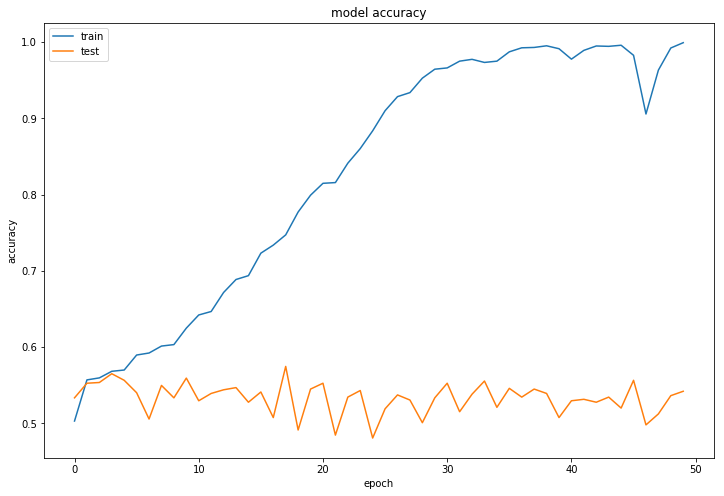

In [174]:
plt.figure(figsize=(12,8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [175]:
model_json = model.net.to_json()
with open('params/model_params_genre_v2.json', "w") as f:
    f.write(model_json)
model.net.save_weights("params/model_params_genre_v2.h5")

In [144]:
latent_embeddings = model.embedding.predict([chroma_features, mfcc_features, embeddings])

In [150]:
print(latent_embeddings.shape)

(5488, 50)


In [151]:
np.save(open("data/latent_embeddings.npy", "wb"), latent_embeddings)

In [60]:
with open('data/embedding.pickle', "rb") as f:
    u = pickle.load(f)
print(len(u))
with open('data/embedding_ids.pickle', "rb") as f:
    v = pickle.load(f)
print(len(v))
print(v[0])

210519
210519
TRAAAAV128F421A322


In [84]:
embeddings_dict = {}
for i in range(len(v)):
    embeddings_dict[v[i]] = u[i]


In [161]:
  
f = open("data/track_ids.txt", "r")
track_ids = f.readlines()
f.close()
print(track_ids[0].strip())

with open("data/mfcc.npy", "rb") as f:
    mfcc_features = np.load(f)
with open("data/chroma.npy", "rb") as f:
    chroma_features = np.load(f)
with open("data/genre_onehot.npy", "rb") as f:
    y = np.load(f)
# y = y.reshape((int(y.shape[0]/num_genres), num_genres))
print(y.shape) 
print(mfcc_features.shape)
relevant_track_ids = []
embeddings = []
delete_indices = []
for i in range(len(track_ids)):
    if i%1000==0:
        print(i)
    if embeddings_dict.get(track_ids[i].strip()) is not None:
        embeddings += [np.array(embeddings_dict[track_ids[i].strip()])[0]]
        relevant_track_ids += [track_ids[i]]
    else:
        delete_indices += [i]
        
chroma_features = np.delete(chroma_features, delete_indices, axis=0)
mfcc_features = np.delete(mfcc_features, delete_indices, axis=0)
y = np.delete(y, delete_indices, axis=0)

embeddings = np.array(embeddings)
print(embeddings.shape)

TRMMMTK128F424EF7C
(12022, 18)
(12022, 300, 12)
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
(6521, 300)


In [164]:
embeddings = np.array(embeddings)
print(embeddings.shape)
print(mfcc_features.shape)
print(y.shape)

(6521, 300)
(6521, 300, 12)
(6521, 18)


In [163]:
print(len(relevant_track_ids))
print(len(list(set(relevant_track_ids))))

6521
6521


In [165]:
np.save(open("data/chroma.npy", "wb"), chroma_features)
np.save(open("data/mfcc.npy", "wb"), mfcc_features)
np.save(open("data/genre_onehot.npy", "wb"), y)
np.save(open("data/embeddings.npy", "wb"), embeddings) 
f = open("data/track_ids.txt", "w")
for track in relevant_track_ids:
    f.write(track+"\n")
f.close()

In [154]:
  
f = open("data/track_ids.txt", "r")
track_ids = f.readlines()
print(len(track_ids))
s = set(track_ids)
print(len(list(s)))
f.close()

10976
2922


In [158]:
!pip install pydot
from keras.utils.vis_utils import plot_model
plot_model(model.net, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You are using pip version 10.0.1, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [1]:
import keras
from keras_self_attention import SeqSelfAttention

Using TensorFlow backend.


In [ ]:
import keras
from keras_self_attention import SeqSelfAttention

class AudioLSTMModel():
    def __init__(self, num_lstm_layers, LSTM_hidden_state_dim, num_time_frames, num_freq_bins, num_genres, lyrics_embedding_dimension, use_attention):
        
        self.num_time_frames = num_time_frames

        self.chroma_input = Input(shape=(num_frames, num_freq_bins))
        self.mfcc_input = Input(shape=(num_frames, num_freq_bins))
        self.lyrics_embedding_input = Input(shape=(embedding_dimension,))
        self.use_attention = use_attention
        
        
        # chroma LSTM and attention
        chroma = keras.layers.LSTM(units=LSTM_hidden_state_dim, return_state=True, input_shape=(self.num_frames, self.num_freq_bins))(self.chroma_input)
        for _ in range(num_lstm_layers - 1):
            chroma = keras.layers.LSTM(units=LSTM_hidden_state_dim, return_state=True)(chroma)
        
        if self.use_attention:
            chroma = SeqSelfAttention(attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL, name='AttentionChroma')(chroma)
        
        # MFCC LSTM and attetion
        mfcc = keras.layers.LSTM(units=LSTM_hidden_state_dim, return_state=True, input_shape=(self.num_frames, self.num_freq_bins))(self.mfcc_input)
        for _ in range(num_lstm_layers - 1):
            mfcc = keras.layers.LSTM(units=LSTM_hidden_state_dim, return_state=True)(mfcc)
        
        if self.use_attention:
            mfcc = SeqSelfAttention(attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL, name='AttentionMFCC')(mfcc)
                
        
        # concatinating the mfcc chroma and embedding features
        x = concatenate([mfcc, chroma, self.embedding_input])

        # putting the features through a couple fcnn. 
        x = Dense(2048, activation='relu')(x)
        x = Dense(2048, activation='relu')(x)
        
        # the embedding vector for each song. 
        latent_embedding = Dense(50, activation='relu', name='embedding')(x)
        genre = Dense(num_genres, activation='softmax')(latent_embedding)
        self.net = Model(inputs=[self.chroma_input, self.mfcc_input, self.embedding_input], outputs=genre)
        self.embedding = Model(self.net.input, outputs=self.net.get_layer('embedding').output)